In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [5]:
def process_image(image_path):
    test_hard3 = cv2.imread(image_path)

    gray = cv2.cvtColor(test_hard3, cv2.COLOR_BGR2GRAY)

    blurred = cv2.GaussianBlur(gray, (19, 19), 0)

    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    thresh = cv2.bitwise_not(thresh)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 6)) # dikey çizgileri birleştirmek için 1,6
    closed_image = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(closed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    contour_image = np.zeros_like(gray)  # Create a blank image (same size as gray)
    cv2.drawContours(contour_image, contours, -1, (255, 255, 255), thickness = cv2.FILLED)  # Draw contours in white

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(contour_image, 8, cv2.CV_32S)
    connected_component_image = labels.copy()
    filtered_components = np.zeros(contour_image.shape, dtype=np.uint8)
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] > 1100:
            filtered_components[labels == i] = 255

    kernel_2 = cv2.getStructuringElement(cv2.MORPH_RECT, (19, 19)) # dikey çizgileri birleştirmek için
    open_image = cv2.morphologyEx(filtered_components, cv2.MORPH_OPEN, kernel_2)

    num_labels_2, labels_2, stats_2, centroids_2 = cv2.connectedComponentsWithStats(open_image, 8, cv2.CV_32S)
    connected_component_image_2 = labels_2.copy()
    filtered_components_2 = np.zeros(open_image.shape, dtype=np.uint8)

    extracted_components = np.zeros_like(gray)

    for i in range(1, num_labels_2):
        ratio = stats_2[i, cv2.CC_STAT_WIDTH] / stats_2[i, cv2.CC_STAT_HEIGHT]

        if 2.5 < ratio < 4:
            filtered_components_2[labels_2 == i] = 255
            print(ratio)
            component_mask = (labels_2 == i)

            extracted_component = gray * component_mask
            sum_of_component = np.sum(extracted_component)
            mean = sum_of_component / stats_2[i, cv2.CC_STAT_AREA]
            print("mean", mean)
            if mean > 80:
                extracted_components += extracted_component

    return extracted_components


libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


3.2753623188405796
mean 90.48515844364219
3.689655172413793
mean 99.676278398298
2.89247311827957
mean 91.62975935655446
2.689655172413793
mean 46.12609478104379
2.5714285714285716
mean 86.3023679417122
2.607142857142857
mean 80.45724713242961
2.98
mean 99.99197132616487


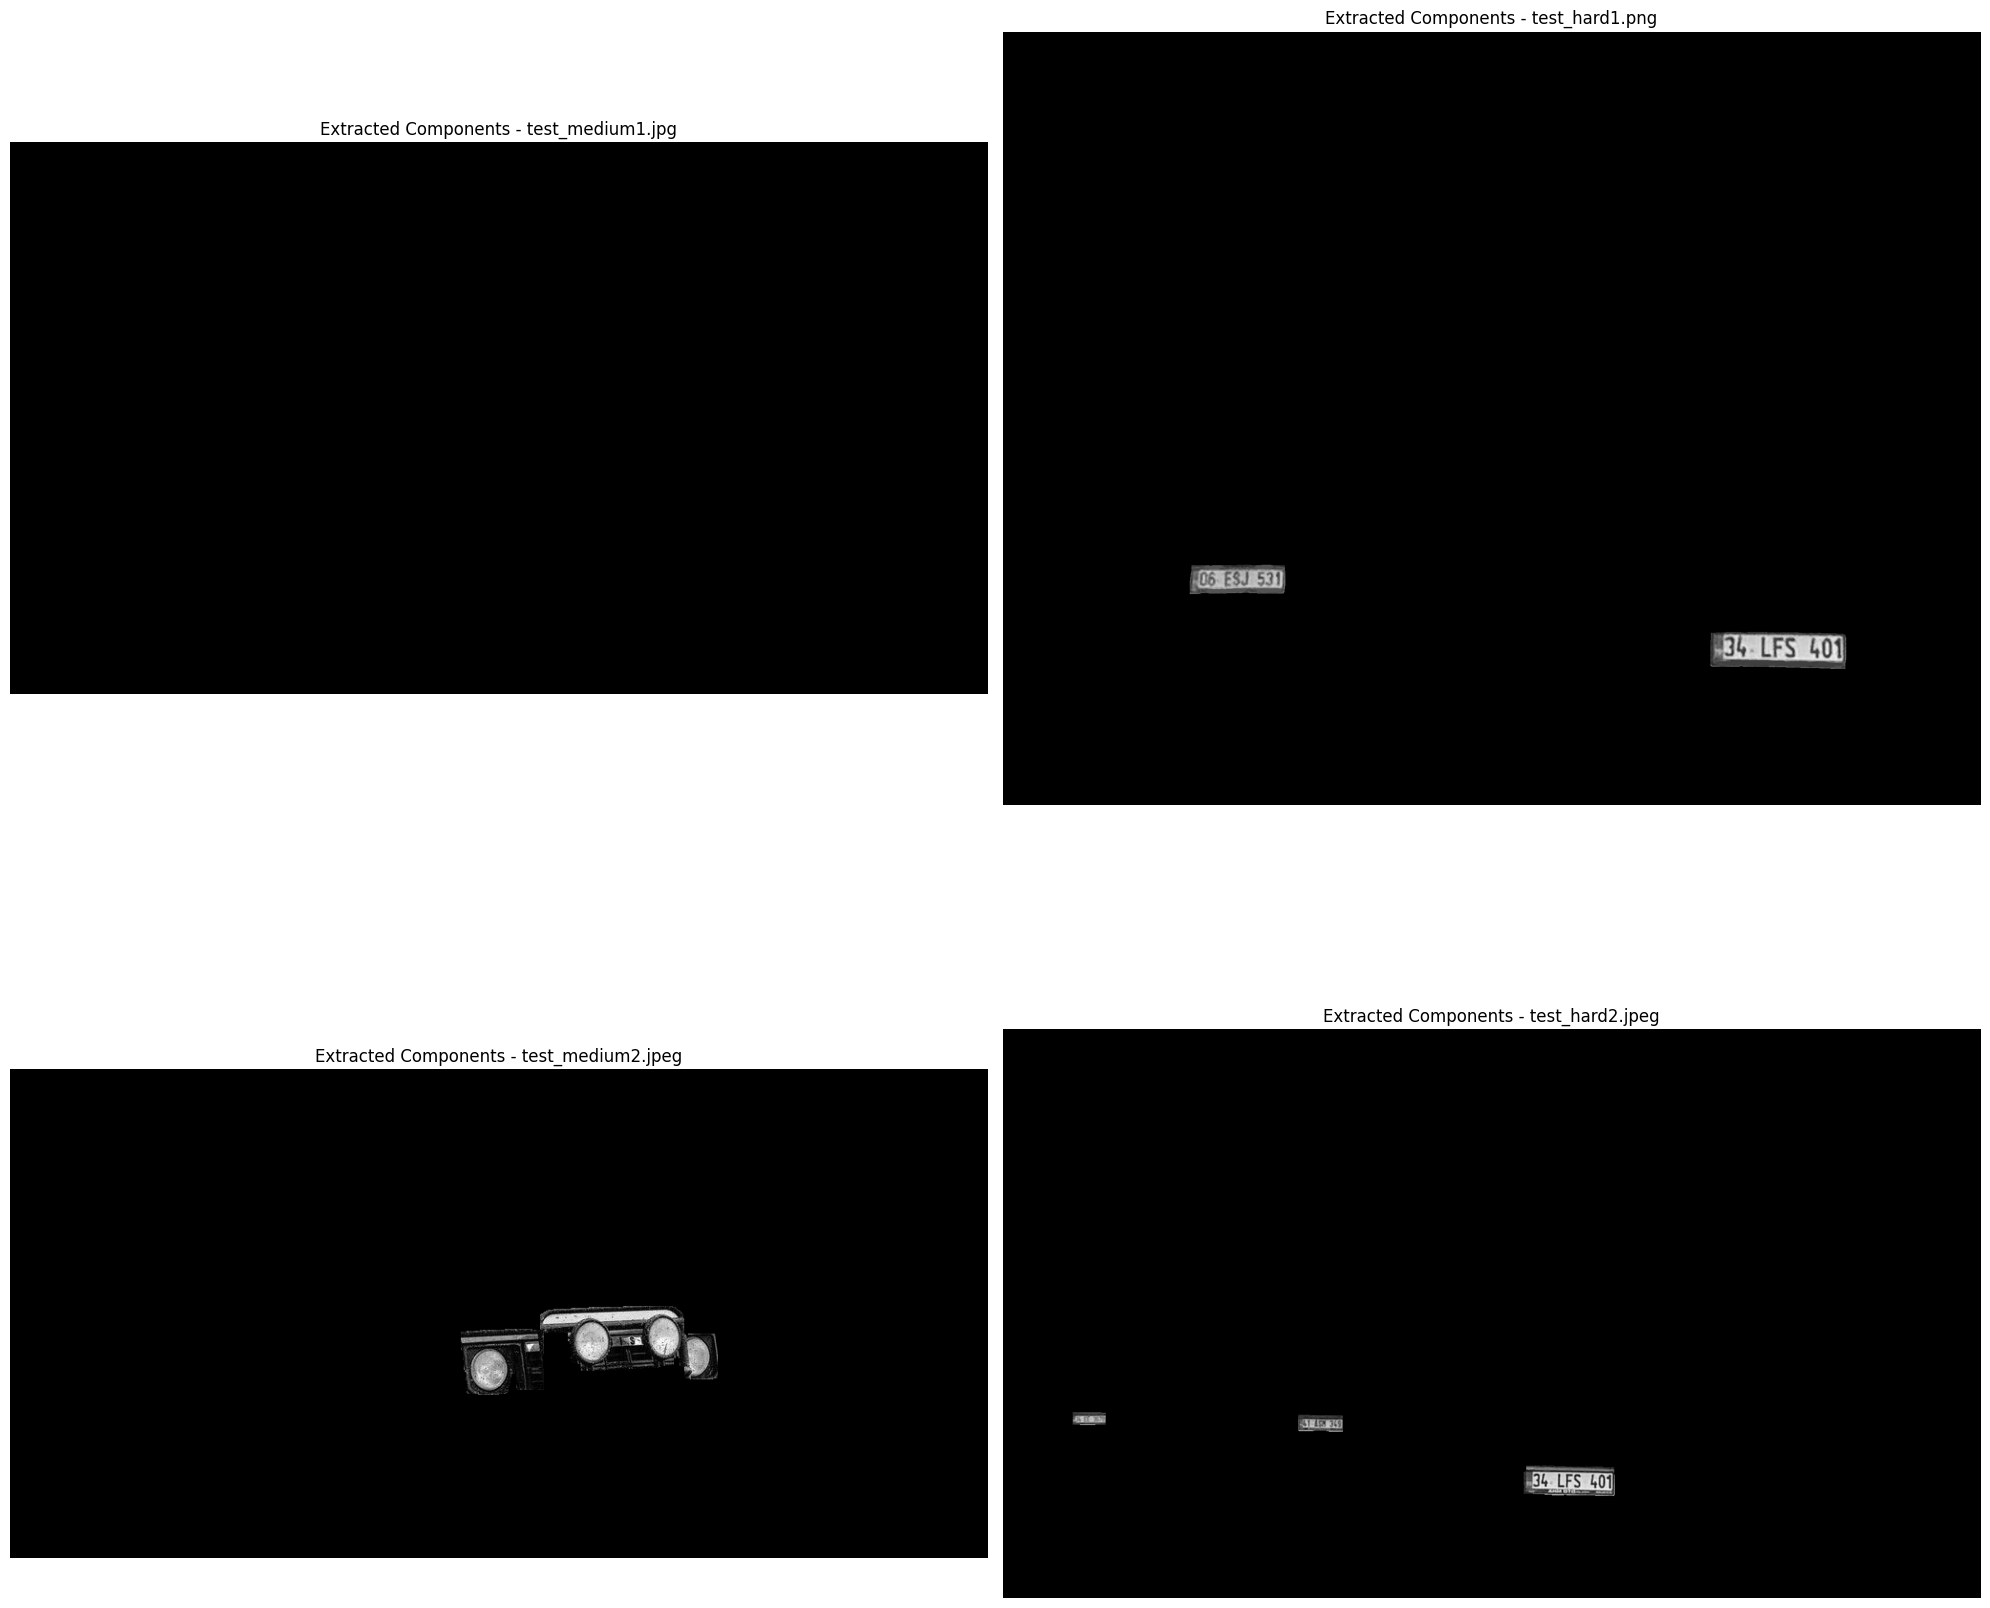

2.830188679245283
mean 72.40504302581549
3.018181818181818
mean 72.31504301325273
3.6853932584269664
mean 98.63833535606624
3.6377952755905514
mean 82.9141288373612
3.4782608695652173
mean 60.835972850678736


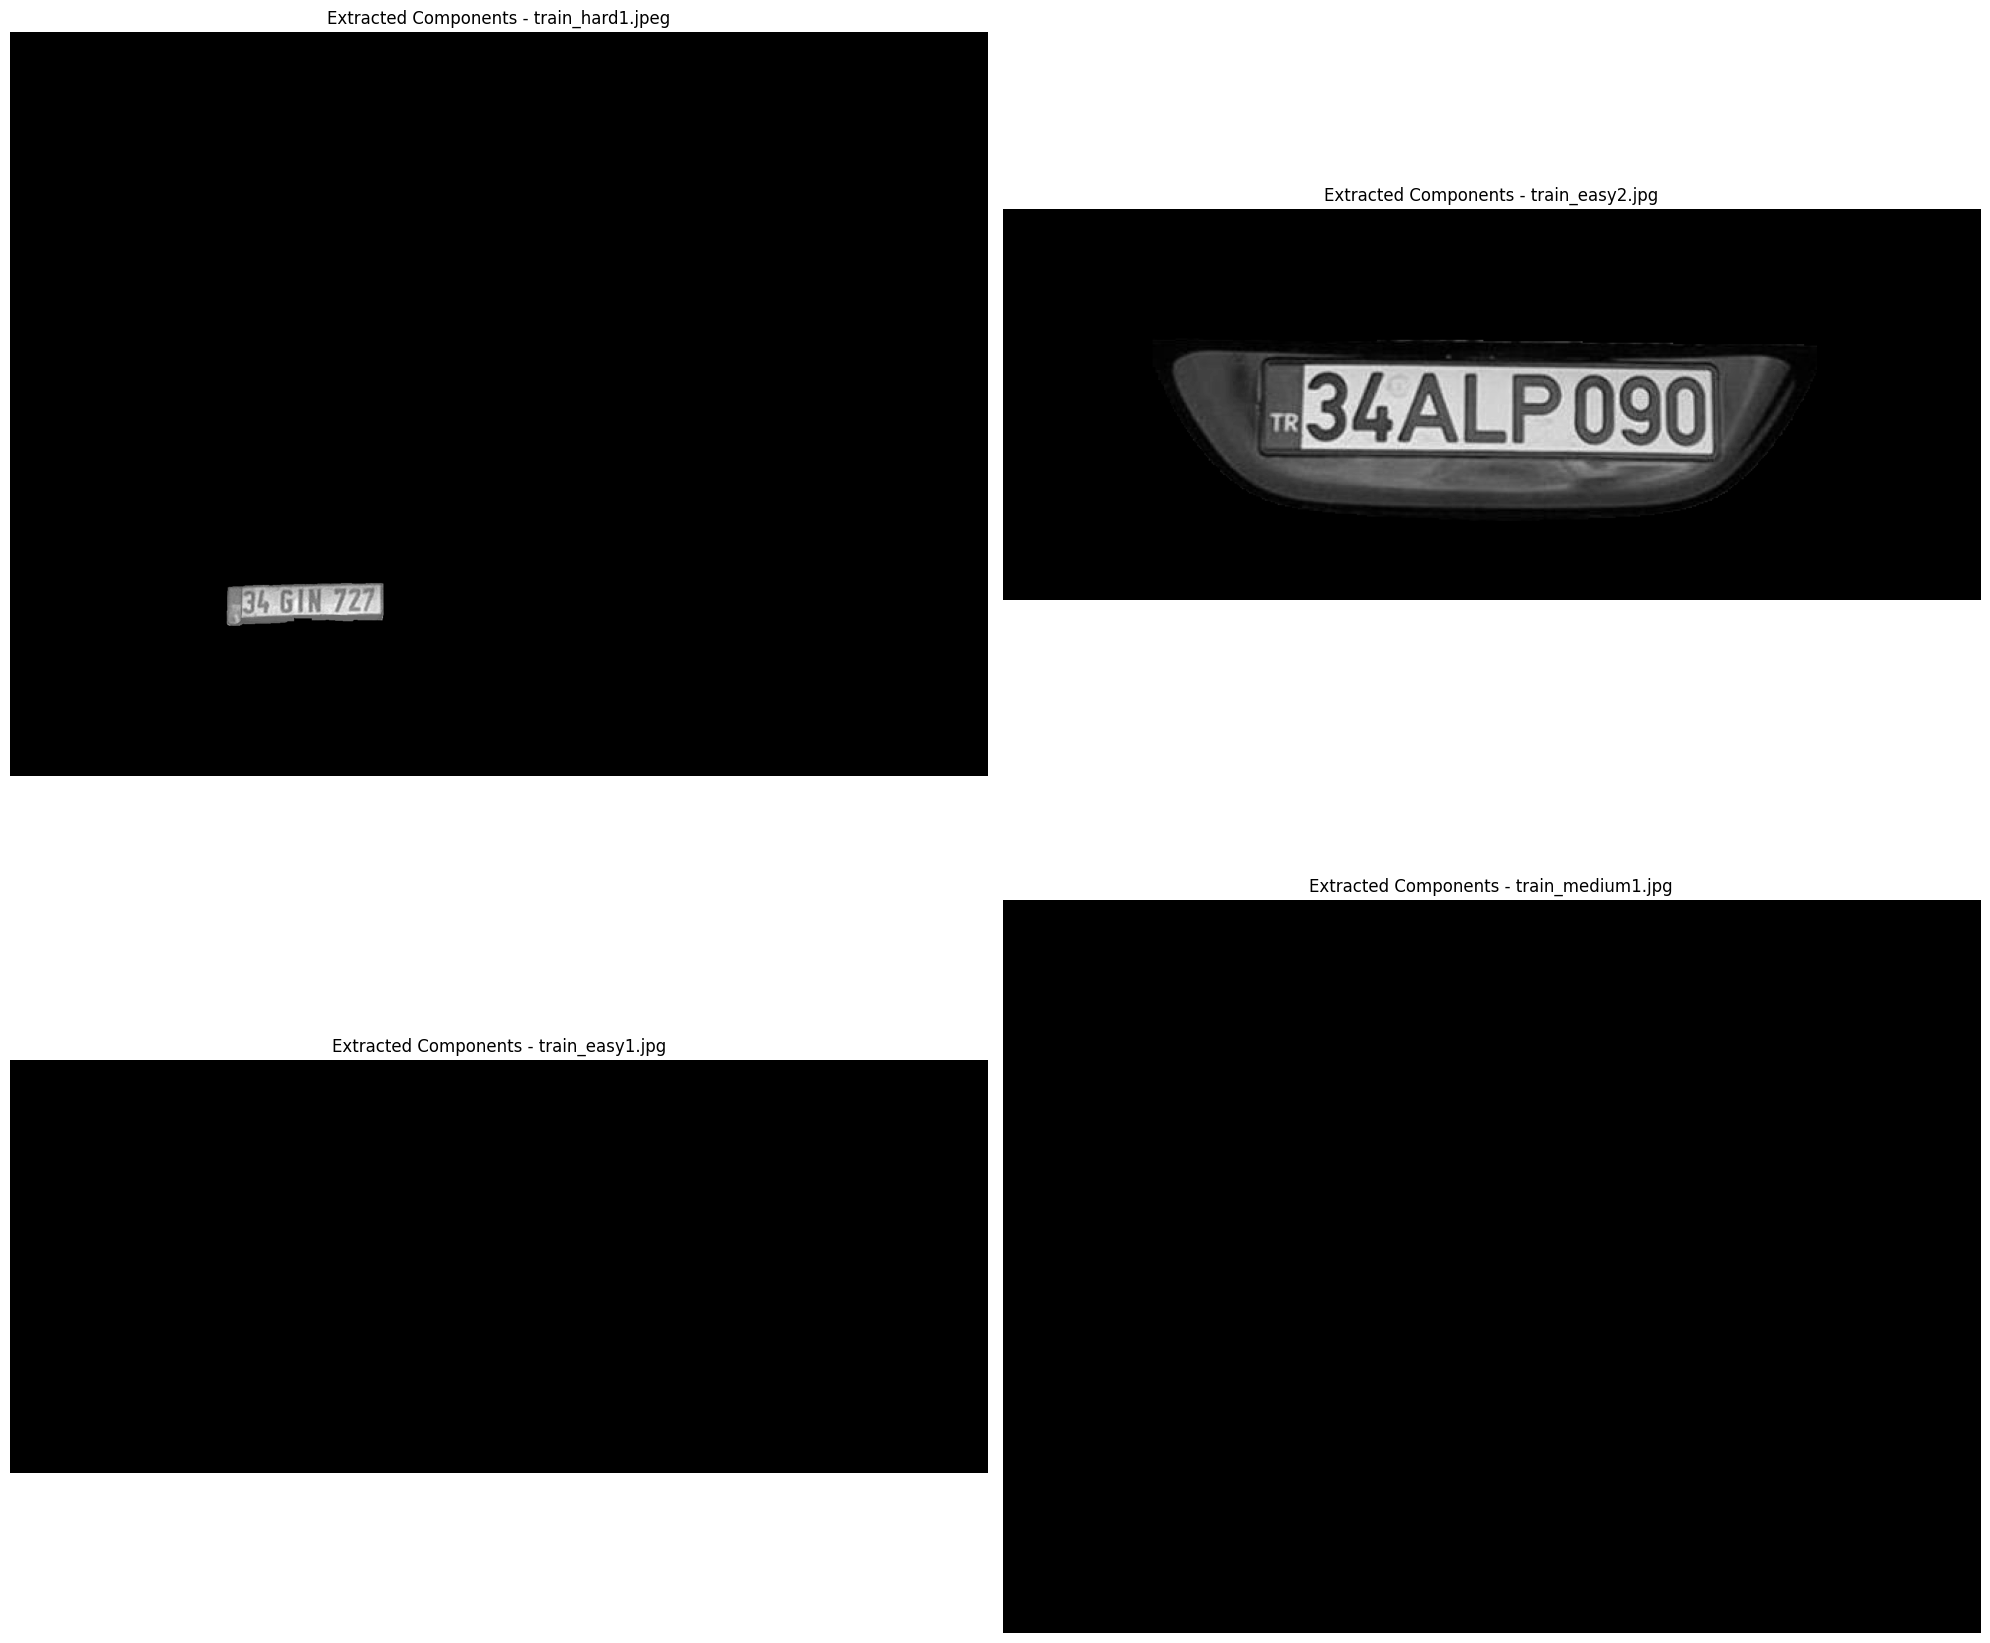

In [10]:
def plot_extracted_components(folder_path):
    images = []
    filenames = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg"):
            image_path = os.path.join(folder_path, filename)
            extracted_components = process_image(image_path)
            images.append(extracted_components)
            filenames.append(filename)
    
    num_images = len(images)
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
    axes = axes.flatten()
    
    for i in range(min(num_images, 8)):
        axes[i].imshow(images[i], cmap='gray')
        axes[i].set_title(f"Extracted Components - {filenames[i]}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()


# Plot extracted components for images in 'test_images' folder
plot_extracted_components('images_gray/test_images/')

# Plot extracted components for images in 'train_images' folder
plot_extracted_components('images_gray/train_images/')